# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

- Is there anything in the data that might explain differences in behavior?

- Can you identify patterns or trends related to when the model succeeds or fails?

- Are there signals or features that seem to affect the model’s reliability?

- What could be done in the short term to handle the current situation?

- What are potential long-term steps to improve model performance in similar scenarios?

- What would you want to explore further if given more time or data?

- What assumptions did the model rely on during training — and are they still valid?

In [1]:
# # Data Preparation for Log Transformation and Plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import joblib  

features_df = pd.read_csv('inference.xls')  
preds_df = pd.read_csv('model_predictions.csv') 

merged = features_df.merge(preds_df, on='sample_id', how='inner')  

inf_preds = merged['prediction']  
y_inf_true = merged['true_label'] 
X_inf = merged.drop(columns=['sample_id', 'true_label', 'prediction']) 

x_energy = X_inf['x_energy']  
bins = np.linspace(x_energy.min(), x_energy.max(), 11)
bin_ids = np.digitize(x_energy, bins) - 1

model = joblib.load('models/imu_pipeline.pkl') 

probs = model.predict_proba(X_inf)  

C:\Users\dani\sensor-analysis-assignment\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\dani\sensor-analysis-assignment\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\dani\sensor-analysis-assignment\venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassi

## 1. What do you observe when comparing the model's predictions on the new data to its known performance?

The model performs well on the original test set, with high accuracy (94.5%) and minimal confusion between collision and normal events. However, on the new inference data, it shows a large increase in false positives—normal driving behavior is often misclassified as collisions. This represents a significant drop in precision, especially for the collision class, while recall remains relatively high. Specifically, overall accuracy drops from 94.5% on the test set to 65% on the new data.

**Bottom line:**  
Performance is strong in validation, but on new data, the model becomes overly sensitive and less reliable.

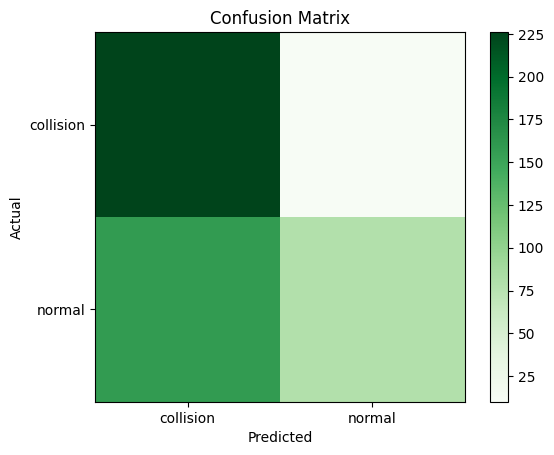

In [2]:
cm = confusion_matrix(y_inf_true, inf_preds, labels=['collision', 'normal'])
plt.imshow(cm, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['collision', 'normal'])
plt.yticks([0, 1], ['collision', 'normal'])
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

The confusion matrix shows that the model predicts almost all "collision" events correctly, but it often misclassifies normal driving as collisions in the inference data. This supports the observation that the model has become over-sensitive to collision signals. This may trigger too many collision-alerts in production, increasing manual review workload.

## 2. Is there anything in the data that might explain differences in behavior?

Both datasets have the same balance: 50% "collision" and 50% "normal."  
However, the key difference lies in the sensor values-features such as 'x_energy' and 'mag_max' are much higher in the inference data than in the validation set, and several other fields show a similar shift. This indicates that the model is encountering conditions outside those represented during training, which likely prevents its learned rules from generalizing and contributes to the observed decrease in accuracy.


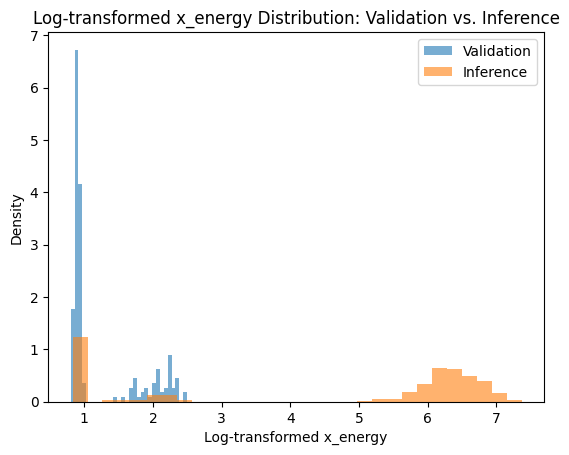

In [4]:
valid_df = pd.read_csv('test.csv')  
inf_df = pd.read_csv('inference.csv')  

valid_df['x_energy_log'] = np.log(valid_df['x_energy'])  # Log-transform validation set
inf_df['x_energy_log'] = np.log(inf_df['x_energy'])  # Log-transform inference set


plt.hist(valid_df['x_energy_log'], bins=30, alpha=0.6, label='Validation', density=True)
plt.hist(inf_df['x_energy_log'], bins=30, alpha=0.6, label='Inference', density=True)


plt.xlabel('Log-transformed x_energy')
plt.ylabel('Density')
plt.title('Log-transformed x_energy Distribution: Validation vs. Inference')
plt.legend()
plt.show()


The new interface data has much higher values for these features compared to validation.  
This indicates that the model is encountering conditions outside those represented during training, which likely contributes to its reduced performance.

## 3. Can you identify patterns or trends related to when the model succeeds or fails?

The model does well at catching real collisions, even on the new data.

But when features like "x_energy" or "mag_max" are much higher than usual, it defaults to predicting "collision", even if it's just normal driving. When the sensor data looks similar to what it saw during training, it still works as expected.


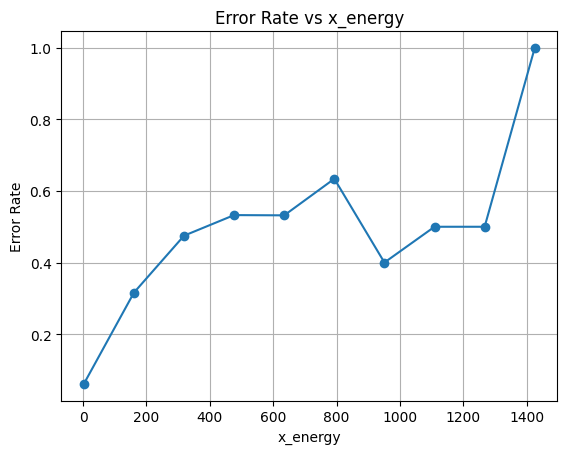

In [5]:
bins = np.linspace(x_energy.min(), x_energy.max(), 11)
bin_ids = np.digitize(x_energy, bins) - 1


error_rate = []
for i in range(10):
    idx = (bin_ids == i)
    if np.sum(idx) > 0:
        rate = (inf_preds[idx] != y_inf_true.values[idx]).mean()  # inf_preds are predictions
        error_rate.append(rate)
    else:
        error_rate.append(np.nan)


plt.plot(bins[:-1], error_rate, marker='o', linestyle='-', color='tab:blue')
plt.xlabel('x_energy')
plt.ylabel('Error Rate')
plt.title('Error Rate vs x_energy')
plt.grid(True)
plt.show()

The error rate plot demonstrates that as 'x_energy' increases, the model makes more mistakes on the inference data. This confirms that the model is less reliable for higher values of this feature, as expected from the data drift analysis.


## 4. Are there signals or features that seem to affect the model's reliability?

Yes. When features such as sudden_change_score or x_energy take on much higher values than what the model encountered during training, the likelihood of incorrect predictions increases substantially. Even relatively small shifts in sensor calibration or environmental conditions can impact these features and make the model less reliable. Overall, the model appears particularly sensitive to unusually large values in these sensor readings, which leads to more frequent misclassifications.


## 5. What could be done in the short term to handle the current situation?
The first steps should be to ensure that data cleaning and scaling procedures are consistent between the training and interface stage. It is also important to flag or manually review any outlier events that differ significantly from the original training data. If possible, gathering and labeling new examples from the current environment and retraining or fine-tuning the model can help restore performance. Additionally, setting up alerts for significant shifts in sensor values or feature distributions can provide early warning for emerging issues, helping to address problems before they have a major impact.

## 6. What are potential long-term steps to improve model performance in similar scenarios?

In the long term, it is important to regularly monitor key feature distributions for signs of drift using statistical summaries, dashboards, and visualizations. Expanding the training dataset to include a broader range of sensor types, devices, road conditions, and environments will help improve the model's reliability. Simulating or collecting additional rare or edge-case events can further strengthen the model's ability to generalize to new situations. Using models and approaches that can adjust to changes in the data, along with a plan to retrain the model regularly when needed, will help keep accuracy and reliability high over time.



## 7. What would you want to explore further if given more time or data?

To better understand and address the model's challenges, I would take the following steps:

1. **Validate Data Quality:**  
   Systematically check for missing, inconsistent, or unexpected values in both features and labels using summary statistics and visual inspection.

2. **Ensure Label Consistency:**  
   Confirm that label definitions and annotation standards are consistent across all datasets by reviewing documentation and sampling labeled data for verification.

3. **Monitor Trends and Segment Performance:**  
   Analyze trends in key features and model errors over time, across different locations, devices, or other relevant segments. Build interactive dashboards to continuously monitor these metrics and quickly detect unusual patterns.

4. **Investigate Feature Impact:**  
   Use feature importance analysis and targeted visualizations to identify which variables most influence model predictions and errors.


## 8. What assumptions did the model rely on during training - and are they still valid?

The model was trained with the expectation that new data would have similar patterns and sensor settings as the training data. When those conditions changed, the model's predictions became less accurate and reliable.
